In [9]:
import numpy as np
import os
import glob
import logging
import json
import sys
sys.path.append("/workspace/zecheng/modelzipper/projects")
from tqdm import tqdm
from concurrent import futures
from argparse import ArgumentParser
from change_deepsvg.svglib.svg import SVG
from change_deepsvg.svglib.geom import Bbox, Angle, Point
from change_deepsvg.difflib.tensor import SVGTensor
from modelzipper.tutils import *
import torch
from tqdm import trange
from PIL import Image
import cairosvg

# content = auto_read_data("/zecheng2/vqllama/test_vqllama_quantizer/test_8/epoch_84/compress_level_1_predictions.pkl")

def sanint_check_svg_tensor(x):
    """
    x: batch_size x seq_len x (7, 9)
    """
    if x.ndim == 2:
        x = x.unsqueeze(0)
    if x.size(-1) == 9:
        x[:, :, 0][x[:, :, 0] == 100] = 1
        x[:, :, 0][x[:, :, 0] == 200] = 2
    elif x.size(-1) == 7:
        # add two columns
        x_0_y_0 = torch.zeros((x.size(0), x.size(1), 2), dtype=x.dtype, device=x.device)
        x_0_y_0[:, 1:, 0] = x[:, :-1, -2]  # x_3 of the previous row
        x_0_y_0[:, 1:, 1] = x[:, :-1, -1]  # y_3 of the previous row
        x = torch.cat((x[:, :, :1], x_0_y_0, x[:, :, 1:]), dim=2)
    return x

def convert_svg(t, colored=False):
    svg = SVGTensor.from_data(t)
    svg = SVG.from_tensor(svg.data, viewbox=Bbox(200))
    svg.numericalize(n=200)
    if colored:
        import pdb; pdb.set_trace()
        svg = svg.normalize().split_paths().set_color("random")
    str_svg = svg.to_str()
    return svg, str_svg


def merge_images(
        image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10,
    ):
    image_list = []
    for image_path in image_path_lst:
        image = Image.open(image_path)
        image_list.append(image)

    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    big_image_size = (sub_image_w * image_row, sub_image_h * image_col)
    big_image = Image.new('RGB', big_image_size)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_row
        col = i % image_col
        big_image.paste(image, (col * image.size[0], row * image.size[1]))
        
        if (i + 1) % (image_row * image_col) == 0:
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size)

    return big_images

def open_image_with_gray_background(image_path, background_color=(255, 255, 255)):  
    # 打开图片并转换为RGBA模式以处理透明度  
    image = Image.open(image_path).convert('RGBA')  
      
    # 创建一个与原图大小相同的灰色背景图像  
    gray_background = Image.new('RGBA', image.size, background_color + (255,))  
      
    # 将原始图像粘贴到灰色背景图像上，透明部分将显示为灰色  
    combined_image = Image.alpha_composite(gray_background, image)  
      
    # 将合成图像转换回RGB模式，以便用于其他不支持透明度的操作  
    combined_image = combined_image.convert('RGB')  
      
    return combined_image 

def merge_images2(
    image_path_lst, raw_image_size_w=None, raw_image_size_h=None, image_row=10, image_col=10, gap_size=10, c_gap_size=10, grid_color=(0, 0, 0), scale_factor=2.0, 
):
    image_list = []
    for image_path in image_path_lst:
        image = open_image_with_gray_background(image_path)
        # image = Image.open(image_path).convert('RGB')
        image = image.resize((int(image.size[0] * scale_factor), int(image.size[1] * scale_factor)))  
        image_list.append(image) 

    
    sub_image_w = raw_image_size_w if raw_image_size_w is not None else image_list[0].size[0]
    sub_image_h = raw_image_size_h if raw_image_size_h is not None else image_list[0].size[1]

    # 计算包括网格线和空隙在内的大图尺寸
    total_gap_w = (image_col - 1) * gap_size
    total_gap_h = (image_row - 1) * c_gap_size + c_gap_size
    # print(sub_image_w, image_col, total_gap_w)
    big_image_size = (sub_image_w * image_col + total_gap_w, sub_image_h * image_row + total_gap_h)

    # 创建带有网格线和空隙的大图背景
    big_image = Image.new('RGB', big_image_size, color=grid_color)
    big_images = []

    for i, image in enumerate(image_list):
        i = i % (image_row * image_col)
        row = i // image_col
        col = i % image_col

        x_pos = col * (sub_image_w + gap_size)
        y_pos = row * (sub_image_h + c_gap_size)

        big_image.paste(image, (x_pos, y_pos))
        
        # 每满一张大图，就将其添加到big_images列表中，并创建新的大图
        if (i + 1) % (image_row * image_col) == 0 or (i + 1) == len(image_list):
            big_images.append(big_image)
            big_image = Image.new('RGB', big_image_size, color=grid_color)

    return big_images

def my_save_png(svg_path, save_path):
    cairosvg.svg2png(svg_path, write_to=save_path)

In [14]:
SD_SVG = [
    "/zecheng2/LIVE-Layerwise-Image-Vectorization/analysis/170595426345_clock/output-svg/1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1.svg",
    "/zecheng2/LIVE-Layerwise-Image-Vectorization/analysis/170595419066_car/output-svg/1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1.svg",
    "/zecheng2/LIVE-Layerwise-Image-Vectorization/analysis/170595405261_cloud/output-svg/1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1.svg",
    "/zecheng2/LIVE-Layerwise-Image-Vectorization/analysis/170595400381_bulb/output-svg/1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1-1.svg"
]


VF = [
    "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis/VF_Blub.svg",
    "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis/VF_car.svg",
    "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis/VF_clock.svg",
    "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis/VF_cloud.svg",
]

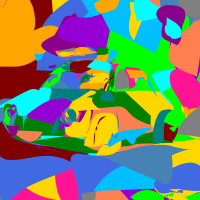

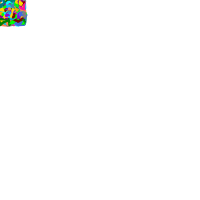

In [32]:
# with open(VF[1], "r") as f:
#     content = f.read()

# my_save_png(content, "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis/VF_car.png")

gen_svg = SVG.load_svg(VF[1])
gen_svg.normalize().split_paths().set_color("random_random").draw()
# gen_svg.normalize().split_paths().draw_colored(fill=True)
svg_tensor = gen_svg.to_tensor()
svg = SVGTensor.from_data(svg_tensor)
svg_ = SVG.from_tensor(svg.data, viewbox=Bbox(200))
svg_.normalize().draw_colored(fill=True)



# analysis_dir = "/workspace/zecheng/modelzipper/projects/custom_llama/baselines/analysis"
# with open(VF[0], "r") as f:
#     content = f.read()
# print(content)
# gen_svg = SVG.from_str(content)
# svg_tensor = gen_svg.to_tensor()
# svg = SVGTensor.from_data(svg_tensor)
# svg_ = SVG.from_tensor(svg.data, viewbox=Bbox(200))
# file_path = os.path.join(analysis_dir, f"clock_image_LIVE.png")
# _ = svg_.normalize().draw_colored(fill=True, file_path=file_path)